In [12]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# Set up environment variables
project_id = 'eighth-arbor-396212'

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


In [13]:
def generate_vital_sign_item_codes(vital_sign, conditions):
    conditions_str = " OR ".join([f"LOWER(d.label) LIKE '{condition}'" for condition in conditions])
    cte_sql = f"""
    {vital_sign} AS (
        SELECT *
        FROM `physionet-data.mimiciv_icu.d_items` d
        WHERE {conditions_str}
    )
    """
    return cte_sql

# Define vital signs and their corresponding SQL conditions
vital_sign_conditions = {
    'HeartRate': ["%heart rate%"],
    'BloodPressure': ["%blood pressure%", "%bp%"],
    'RespiratoryRate': ["%respiratory rate%", "%resp rate%"],
    'Temperature': ["%temperature%", "%temp%"],
    'OxygenSaturation': ["%oxygen saturation%", "%spo2%"],
}

vital_item_codes = {vital_sign: generate_vital_sign_item_codes(vital_sign, conditions)
            for vital_sign, conditions in vital_sign_conditions.items()}


In [14]:
def generate_vital_sign_features_cte(vital_sign_name, features=None):
    if features is None:
        features = ['AVG', 'MIN', 'MAX', 'STDDEV', 'VARIANCE', 'PERCENTILE_CONT(0.25)', 'PERCENTILE_CONT(0.75)', 'COUNT']

    aggregate_feature_calculations = []
    for feature in features:
        if "PERCENTILE_CONT" in feature:
            percentile = feature.replace("PERCENTILE_CONT(", "").replace(")", "")
            feature_str = f"APPROX_QUANTILES(valuenum, 100)[SAFE_OFFSET({int(float(percentile) * 100)})] AS percentile_cont_{percentile.replace('.', '_')}{vital_sign_name.lower()}"
        else:
            feature_str = f"{feature}(valuenum) AS {feature.lower()}{vital_sign_name.lower()}"
        aggregate_feature_calculations.append(feature_str)

    aggregate_feature_calculations = ', '.join(aggregate_feature_calculations)


    cte_sql = f"""
    {vital_sign_name}GeneralFeatures AS (
        SELECT DISTINCT subject_id, hadm_id, stay_id,
               {aggregate_feature_calculations}
        FROM `physionet-data.mimiciv_icu.chartevents`
        WHERE itemid IN (SELECT itemid FROM {vital_sign_name})
        GROUP BY subject_id, hadm_id, stay_id
    )
    """

    return cte_sql

vital_signs_general_data = {vital_sign: generate_vital_sign_features_cte(vital_sign)
                              for vital_sign in vital_sign_conditions}

In [15]:
def generate_window_vital_sign_features_cte(vital_sign_name, features=None):
    if features is None:
        features = ['FIRST_VALUE', 'LAST_VALUE']

    window_feature_calculations = ', '.join([
        f"{feature}(valuenum) OVER (PARTITION BY subject_id, hadm_id, stay_id ORDER BY charttime) AS {feature.lower().replace('(','_').replace(')','_').replace('.','_')}{vital_sign_name.lower()}"
        for feature in features
    ])

    rate_of_change_calculation = f"LEAD(valuenum, 1) OVER (PARTITION BY subject_id, hadm_id, stay_id ORDER BY charttime) - valuenum AS rate_of_change_{vital_sign_name.lower()}"

    cte_sql = f"""
    {vital_sign_name}WindowFeatures AS (
        SELECT subject_id, hadm_id, stay_id, charttime, valuenum,
               {window_feature_calculations},
               {rate_of_change_calculation}
        FROM `physionet-data.mimiciv_icu.chartevents`
        WHERE itemid IN (SELECT itemid FROM {vital_sign_name})
        WINDOW w AS (PARTITION BY subject_id, hadm_id, stay_id ORDER BY charttime)
    )
    """

    return cte_sql

generate_window_vital_signs_dict = {}

for vital_sign in vital_sign_conditions:
    generate_window_vital_signs_dict[vital_sign] = generate_window_vital_sign_features_cte(vital_sign)

In [16]:
def time_difference_data(vital_sign_table, vital_sign_column):
    return f"""
    {vital_sign_table}TimeDifferenceData AS (
        SELECT
            subject_id,
            hadm_id,
            stay_id,
            TIMESTAMP_DIFF(lead(charttime) OVER w, charttime, SECOND) AS time_interval_seconds,
            {vital_sign_column} AS {vital_sign_table.lower()}_rate
        FROM {vital_sign_table}WindowFeatures
        WINDOW w AS (PARTITION BY subject_id, hadm_id, stay_id ORDER BY charttime)
    )"""

time_difference_dict = {}

for vital_sign in vital_sign_conditions:
    time_difference_dict[vital_sign] = time_difference_data(vital_sign, "valuenum")

In [17]:
def vital_signs_clinical_features(lower_bound, upper_bound, vital_sign, condition_low, condition_high):
    return f"""
    {vital_sign}ClinicalFeatures AS (
        SELECT
            subject_id,
            hadm_id,
            stay_id,
            SUM(CASE WHEN {vital_sign.lower()}_rate > {upper_bound} THEN time_interval_seconds ELSE 0 END) AS time_with_{condition_high},
            SUM(CASE WHEN {vital_sign.lower()}_rate < {lower_bound} THEN time_interval_seconds ELSE 0 END) AS time_with_{condition_low},
            COUNTIF({vital_sign.lower()}_rate > {upper_bound}) AS episodes_of_{condition_high},
            COUNTIF({vital_sign.lower()}_rate < {lower_bound}) AS episodes_of_{condition_low}
        FROM {vital_sign}TimeDifferenceData
        GROUP BY subject_id, hadm_id, stay_id
    )"""


# Vital signs with their respective lower and upper bounds
# Hypotension and Hypertension for BloodPressure
# Bradypnea and Tachypnea for RespiratoryRate
# Hypoxemia and Hyperoxia for OxygenSaturation
# Bradycardia and Tachycardia for HeartRate
# Hypothermia and Hyperthermia for Temperature
vital_signs = {
    'BloodPressure': {'lower': 60, 'upper': 180, 'conditions': 'Hypotension, Hypertension'},
    'RespiratoryRate': {'lower': 10, 'upper': 30, 'conditions': 'Bradypnea, Tachypnea'},
    'OxygenSaturation': {'lower': 90, 'upper': 100, 'conditions': 'Hypoxemia, Hyperoxia'},
    'HeartRate': {'lower': 50, 'upper': 100, 'conditions': 'Bradycardia, Tachycardia'},
    'Temperature': {'lower': 35, 'upper': 38, 'conditions': 'Hypothermia, Hyperthermia'},
}

# Create a dictionary to store the Clinical Features CTEs
clinical_features_dict = {}

# Populate the dictionary
for vital_sign, bounds in vital_signs.items():
    lower_bound = bounds['lower']
    upper_bound = bounds['upper']
    condition_low, condition_high = bounds['conditions'].split(', ')
    clinical_features_cte = vital_signs_clinical_features(lower_bound, upper_bound, vital_sign, condition_low, condition_high)
    clinical_features_dict[vital_sign] = clinical_features_cte


In [18]:
def patient_filtering(table_name):
    return f"""
    FilteredPatients AS (
        SELECT *
        FROM `comp90089-hai-patients.hai_patients.{table_name}`
    )"""

hai_positive_patients = patient_filtering('hai_positive_patients')
central_line_patients = patient_filtering('central_line_patients')
urinary_catheter_patients = patient_filtering('urinary_catheter_patients')
ventilator_patients = patient_filtering('ventilator_patients')

filtered_patients = {
    'hai_positive_patients': hai_positive_patients,
    'central_line_patients': central_line_patients,
    'urinary_catheter_patients': urinary_catheter_patients,
    'ventilator_patients': ventilator_patients
}

In [26]:
def join_ctes(cte_dict):
    """
    Joins multiple CTEs into a single SQL string.

    Parameters:
    cte_dict (dict): A dictionary where keys are CTE names and values are CTE SQL strings.

    Returns:
    str: A single SQL string containing all the CTEs.
    """
    cte_list = list(cte_dict.values())

    # Add 'WITH' to the first CTE
    cte_list[0] = "WITH " + cte_list[0].strip()

    # Add trailing comma to all except the last CTE
    cte_list[:-1] = [cte.strip() + "," for cte in cte_list[:-1]]

    # Concatenate all the CTEs
    joined_ctes = " ".join(cte_list)

    return joined_ctes

cte_dict = {}
# Example usage
for patients in filtered_patients:
    cte_dict[patients] = {}
    for vital_sign in vital_sign_conditions:
        cte_dict[patients][vital_sign] = {}
        cte_dict[patients][vital_sign]["FilteredPatients"] = filtered_patients[patients]
        cte_dict[patients][vital_sign][vital_sign] = vital_item_codes[vital_sign]
        cte_dict[patients][vital_sign][f"{vital_sign}GeneralFeatures"] = vital_signs_general_data[vital_sign]
        cte_dict[patients][vital_sign][f"{vital_sign}WindowFeatures"] = generate_window_vital_signs_dict[vital_sign]
        cte_dict[patients][vital_sign][f"{vital_sign}TimeDifferenceData"] = time_difference_dict[vital_sign]
        cte_dict[patients][vital_sign][f"{vital_sign}ClinicalFeatures"] = clinical_features_dict[vital_sign]

joined_ctes = {}

for patients in filtered_patients:
    joined_ctes[patients] = {}
    for vital_sign in vital_sign_conditions:
        joined_ctes[patients][vital_sign] = join_ctes(cte_dict[patients][vital_sign])


In [ ]:
def create_combined_patients_cte(table_names, project_name="comp90089-hai-patients", dataset_name="hai_patients"):
    if not table_names:
        return ''
    
    joins = []
    coalesce_cols = ["COALESCE(" + ", ".join([f"{tbl}.subject_id" for tbl in table_names]) + ") AS subject_id",
                     "COALESCE(" + ", ".join([f"{tbl}.hadm_id" for tbl in table_names]) + ") AS hadm_id",
                     "COALESCE(" + ", ".join([f"{tbl}.stay_id" for tbl in table_names]) + ") AS stay_id"]
    
    base_table = table_names[0]
    for next_table in table_names[1:]:
        join_condition = f"""
        FULL OUTER JOIN
            `{project_name}.{dataset_name}.{next_table}` AS {next_table}
        ON
            {" AND ".join([f"COALESCE({', '.join(table_names[:table_names.index(next_table)+1])}.{col}) = {next_table}.{col}" for col in ['subject_id', 'hadm_id']])}
            AND COALESCE({', '.join(table_names[:table_names.index(next_table)+1])}.stay_id) IS NOT DISTINCT FROM {next_table}.stay_id
        """
        joins.append(join_condition)
    
    cte_sql = f"""
    WITH CombinedPatients AS (
      SELECT
        {', '.join(coalesce_cols)}
      FROM
        `{project_name}.{dataset_name}.{base_table}` AS {base_table}
      {' '.join(joins)}
    )
    """
    return cte_sql

# Example usage:
table_names = ["ventilator_patients", "central_line_patients", "hai_positive_patients", "urinary_catheter_patients"]
cte_query = create_combined_patients_cte(table_names)
print(cte_query)


In [36]:
def vital_signs_select_all(vital_sign_name, ctes, limit=True):

    sql_query = f"""
    {ctes}
    SELECT *
    FROM {vital_sign_name}GeneralFeatures A
    JOIN {vital_sign_name}ClinicalFeatures B
    USING (subject_id, hadm_id, stay_id)
    JOIN FilteredPatients C
    ON A.subject_id = C.subject_id AND A.hadm_id = C.hadm_id AND CAST(A.stay_id AS STRING) = CAST(C.stay_id AS STRING)
    {'LIMIT 1000' if limit else ''}
    """

    return sql_query

hai_positive_patients_queries = {}
central_line_patients_queries = {}
urinary_catheter_patients_queries = {}
ventilator_patients_queries = {}

for patients_key, patients_value in filtered_patients.items():
    # Create an empty dictionary for each vital sign in this group of patients
    vital_signs_queries = {}

    # Loop over each vital sign
    for vital_sign in vital_sign_conditions:
        # Generate the SQL query for this vital sign
        sql_query = vital_signs_select_all(vital_sign, joined_ctes[patients_key][vital_sign], limit=False)

        vital_signs_queries[vital_sign] = sql_query
        print(sql_query)

    if patients_key == 'hai_positive_patients':
        hai_positive_patients_queries = vital_signs_queries
    elif patients_key == 'central_line_patients':
        central_line_patients_queries = vital_signs_queries
    elif patients_key == 'urinary_catheter_patients':
        urinary_catheter_patients_queries = vital_signs_queries
    elif patients_key == 'ventilator_patients':
        ventilator_patients_queries = vital_signs_queries


    WITH FilteredPatients AS (
        SELECT *
        FROM `comp90089-hai-patients.hai_patients.hai_positive_patients`
    ), HeartRate AS (
        SELECT *
        FROM `physionet-data.mimiciv_icu.d_items` d
        WHERE LOWER(d.label) LIKE '%heart rate%'
    ), HeartRateGeneralFeatures AS (
        SELECT DISTINCT subject_id, hadm_id, stay_id,
               AVG(valuenum) AS avgheartrate, MIN(valuenum) AS minheartrate, MAX(valuenum) AS maxheartrate, STDDEV(valuenum) AS stddevheartrate, VARIANCE(valuenum) AS varianceheartrate, APPROX_QUANTILES(valuenum, 100)[SAFE_OFFSET(25)] AS percentile_cont_0_25heartrate, APPROX_QUANTILES(valuenum, 100)[SAFE_OFFSET(75)] AS percentile_cont_0_75heartrate, COUNT(valuenum) AS countheartrate
        FROM `physionet-data.mimiciv_icu.chartevents`
        WHERE itemid IN (SELECT itemid FROM HeartRate)
        GROUP BY subject_id, hadm_id, stay_id
    ), HeartRateWindowFeatures AS (
        SELECT subject_id, hadm_id, stay_id, charttime, valuenum,
    

# Data Cleaning

In [48]:
import pandas as pd

def merge_vital_signs_dataframes(queries_dict):
    # Initialize an empty DataFrame
    merged_df = pd.DataFrame()

    # Loop through each vital_sign condition
    for vital_sign in vital_sign_conditions:
        # Run the query to get the new DataFrame
        new_dataframe = run_query(queries_dict[vital_sign])

        # Check if merged_df is empty (first iteration)
        if merged_df.empty:
            merged_df = new_dataframe
        else:
            # Columns to join on
            join_columns = ['subject_id', 'hadm_id']

            # Add 'stay_id' if it's available in both dataframes
            if 'stay_id' in merged_df.columns and 'stay_id' in new_dataframe.columns:
                join_columns.append('stay_id')

            # Merge the dataframes
            merged_df = pd.merge(merged_df, new_dataframe, on=join_columns, how='outer')

    return merged_df

LOAD_DATA = True

if LOAD_DATA:
    hai_positive_patients_df = pd.read_csv('vital_signs_df/hai_positive_patients_vital_signs.csv')
    # central_line_patients_df = pd.read_csv('vital_signs_df/central_line_patients_vital_signs.csv')
    urinary_catheter_patients_df = pd.read_csv('vital_signs_df/urinary_catheter_patients_vital_signs.csv')
    # ventilator_patients_df = pd.read_csv('vital_signs_df/ventilator_patients_vital_signs.csv')
else:
    hai_positive_patients_df = merge_vital_signs_dataframes(hai_positive_patients_queries)
    central_line_patients_df = merge_vital_signs_dataframes(central_line_patients_queries)
    urinary_catheter_patients_df = merge_vital_signs_dataframes(urinary_catheter_patients_queries)
    ventilator_patients_df = merge_vital_signs_dataframes(ventilator_patients_queries)

    hai_positive_patients_df.to_csv('hai_positive_patients_vital_signs', index=False)
    central_line_patients_df.to_csv('central_line_patients_vital_signs', index=False)
    urinary_catheter_patients_df.to_csv('urinary_catheter_patients_vital_signs', index=False)
    ventilator_patients_df.to_csv('ventilator_patients_vital_signs', index=False)

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import numpy as np
import pandas as pd

def remove_unwanted_columns(df, original_cols):
    unwanted_cols = [col for col in df.columns if any(f"{original_col}_" in col for original_col in original_cols)]
    df.drop(columns=unwanted_cols, inplace=True)
    return df

def remove_or_replace_outliers(df, col, strategy='zscore'):
    col_data = df[col]
    if strategy == 'zscore':
        z_scores = stats.zscore(col_data)
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 3)
        df[col] = col_data[filtered_entries]
    elif strategy == 'iqr':
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        filtered_entries = ((col_data >= (Q1 - 1.5 * IQR)) & (col_data <= (Q3 + 1.5 * IQR)))
        df[col] = col_data[filtered_entries]
    return df

def handle_missing_values(df, col, strategy='mean'):
    if strategy == 'mean':
        df[col].fillna(df[col].mean(), inplace=True)
    elif strategy == 'replace':
        df[col].fillna(-1, inplace=True)
    elif strategy == 'median':
        df[col].fillna(df[col].median(), inplace=True)
    elif strategy == 'drop':
        df.dropna(subset=[col], inplace=True)
    return df

def normalise_or_standardise(df, col, strategy='standardise'):
    col_data = df[col].values.reshape(-1, 1)
    if strategy == 'standardise':
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(col_data)
    elif strategy == 'normalise':
        scaler = MinMaxScaler()
        df[col] = scaler.fit_transform(col_data)
    return df

def clean_df(pre_df, flags, original_cols=['subject_id', 'hadm_id', 'stay_id', 'icd_code', 'long_title', 'HAI_Type']):
    df = pre_df.copy()

    if flags.get('remove_unwanted_cols', False):
        df = remove_unwanted_columns(df, original_cols)
        
    for col in df.columns:
        if 'heartrate' in col or 'bloodpressure' in col or 'respiratoryrate' in col or 'temperature' in col or 'oxygensaturation' in col:
            if flags.get('handle_outliers', False):
                df = remove_or_replace_outliers(df, col, flags.get('outlier_strategy', 'zscore'))
            
            if flags.get('handle_missing', False):
                df = handle_missing_values(df, col, flags.get('imputation', 'mean'))
                
            if flags.get('normalise_data', False):
                df = normalise_or_standardise(df, col, flags.get('normalisation', 'standardise'))
                
    if flags.get('remove_duplicates', False):
        df.drop_duplicates(inplace=True)
        
    return df

# Flags dictionary
flags = {
    'remove_unwanted_cols': True,
    'handle_outliers': True,
    'handle_missing': True,
    'normalise_data': True,
    'remove_duplicates': True,
    'imputation': 'mean',
    'outlier_strategy': 'zscore',
    'normalisation': 'standardise'
}

# Clean each DataFrame
hai_positive_patients_cleaned_df = clean_df(hai_positive_patients_df, flags)
# central_line_patients_cleaned_df = clean_df(central_line_patients_df, flags)
urinary_catheter_patients_cleaned_df = clean_df(urinary_catheter_patients_df, flags)
# ventilator_patients_cleaned_df = clean_df(ventilator_patients_df, flags)


c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\demic\anaconda3\envs\MLHealth\Lib\site-

# Feature Engineering

In [39]:
hai_positive_patients_cleaned_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'avgheartrate', 'minheartrate',
       'maxheartrate', 'stddevheartrate', 'varianceheartrate',
       'percentile_cont_0_25heartrate', 'percentile_cont_0_75heartrate',
       'countheartrate', 'time_with_Tachycardia', 'time_with_Bradycardia',
       'episodes_of_Tachycardia', 'episodes_of_Bradycardia',
       'avgbloodpressure', 'minbloodpressure', 'maxbloodpressure',
       'stddevbloodpressure', 'variancebloodpressure',
       'percentile_cont_0_25bloodpressure',
       'percentile_cont_0_75bloodpressure', 'countbloodpressure',
       'time_with_Hypertension', 'time_with_Hypotension',
       'episodes_of_Hypertension', 'episodes_of_Hypotension',
       'avgrespiratoryrate', 'minrespiratoryrate', 'maxrespiratoryrate',
       'stddevrespiratoryrate', 'variancerespiratoryrate',
       'percentile_cont_0_25respiratoryrate',
       'percentile_cont_0_75respiratoryrate', 'countrespiratoryrate',
       'time_with_Tachypnea', 'time_with_Bradypnea', 

# Exploratory Data Analysis

## Statistical Analysis

In [40]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

def get_numerical_df(df, non_numerical_cols=['subject_id', 'hadm_id', 'stay_id', 'icd_code', 'long_title', 'HAI_Type']):
    numerical_cols = [col for col in df.columns if col not in non_numerical_cols]
    return df[numerical_cols]

# Descriptive Statistics
def descriptive_statistics(df):
    return df.describe()

# Correlation Analysis
def correlation_analysis(df):
    return df.corr()

# Chi-Square Test
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return {
        'Chi-Square Value': chi2,
        'p-value': p,
        'Degrees of Freedom': dof,
        'Expected Frequency Table': expected
    }

# T-Test (Independent samples)
def independent_t_test(df, col, group_col):
    group1 = df[df[group_col] == 0][col]
    group2 = df[df[group_col] == 1][col]
    t_stat, p_val = ttest_ind(group1, group2)
    return {'T-Statistic': t_stat, 'p-value': p_val}

# One-way ANOVA
def one_way_anova(df, col, group_col):
    groups = [df[col][df[group_col] == group] for group in set(df[group_col])]
    f_stat, p_val = f_oneway(*groups)
    return {'F-Statistic': f_stat, 'p-value': p_val}

def print_statistics(df, df_name):
    print(f"------ {df_name} DataFrame ------")
    
    # Get only the numerical columns for statistics and correlation
    df_numerical = get_numerical_df(df)
    
    print("\n== Descriptive Statistics ==")
    print(descriptive_statistics(df_numerical))

    print("\n== Correlation Analysis ==")
    print(correlation_analysis(df_numerical))

    print("------------------------------------\n")


print_statistics(hai_positive_patients_cleaned_df, 'HAI Positive Patients')

------ HAI Positive Patients DataFrame ------

== Descriptive Statistics ==
       avgheartrate  minheartrate  maxheartrate  stddevheartrate  \
count   3413.000000   3413.000000   3413.000000              0.0   
mean      -0.103391      0.121673     -0.063884              NaN   
std        0.986282      0.859182      0.873429              NaN   
min       -3.348353     -4.160204     -0.803208              NaN   
25%       -0.770818     -0.345966     -0.225309              NaN   
50%       -0.138180      0.457031     -0.225309              NaN   
75%        0.533512      0.457031     -0.080835              NaN   
max        4.918946      3.869770     10.610286              NaN   

       varianceheartrate  percentile_cont_0_25heartrate  \
count                0.0                    3413.000000   
mean                 NaN                      -0.077413   
std                  NaN                       0.989491   
min                  NaN                      -2.960546   
25%             

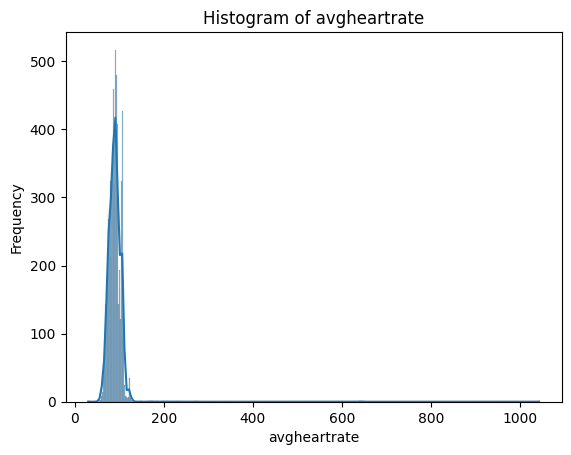

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(df, column):
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(hai_positive_patients_df, 'avgheartrate')



C:\Users\demic\AppData\Local\Temp\ipykernel_14344\2824362385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.dropna(axis=1, how='all', inplace=True)


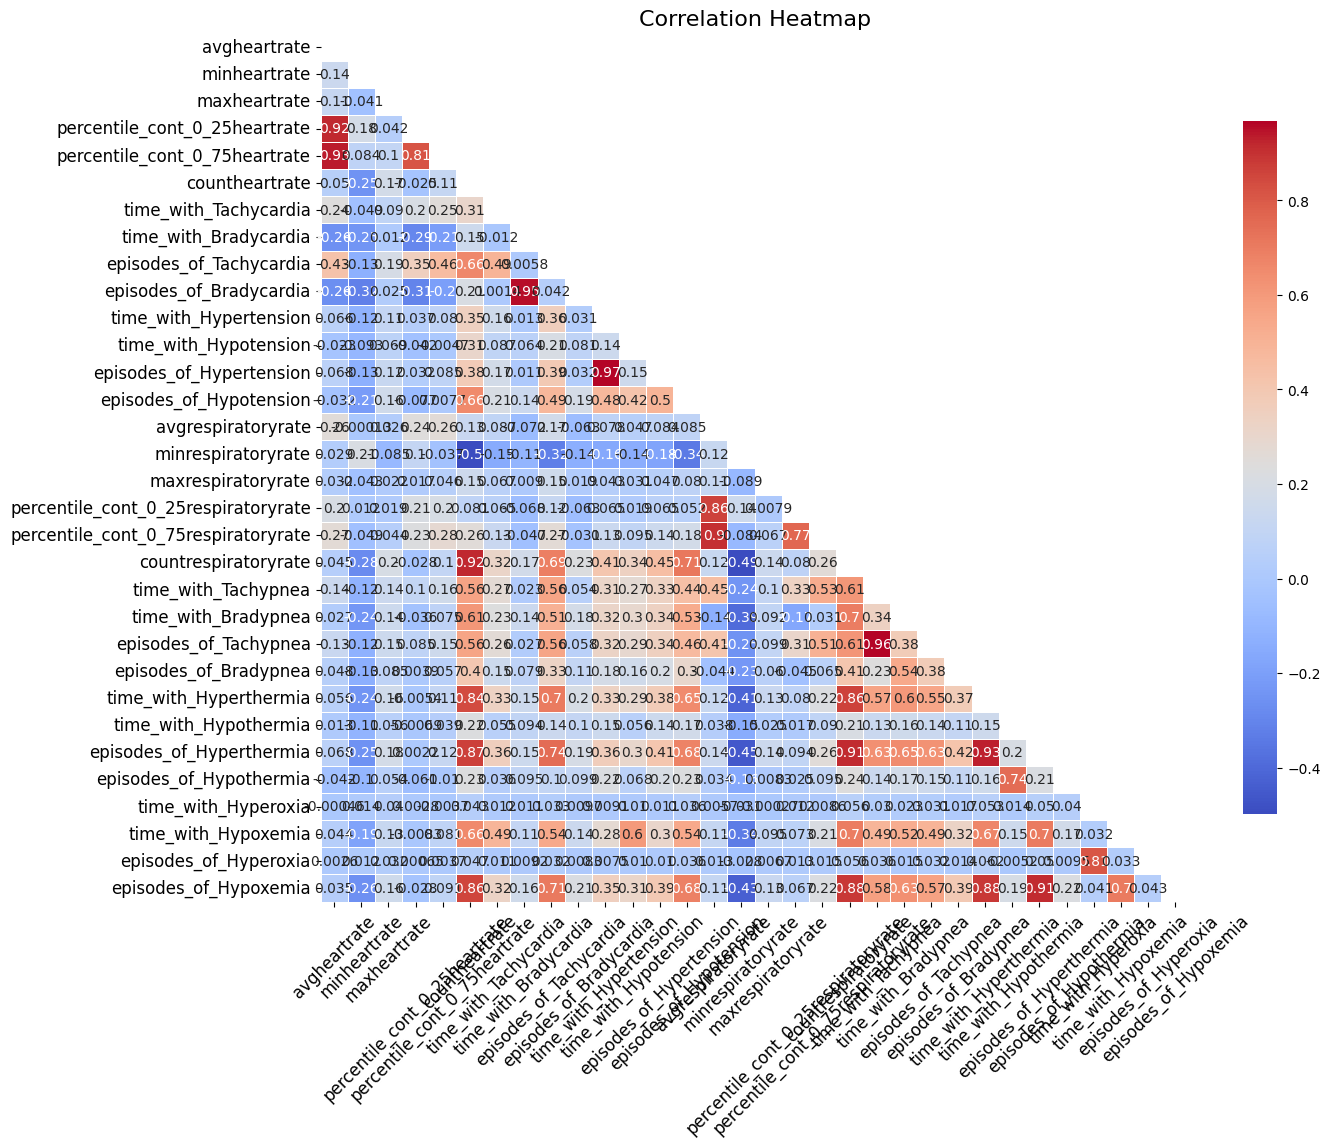

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_heatmap(df):
    df_numerical = get_numerical_df(df)
    
    # Drop columns where all values are NaN
    df_numerical.dropna(axis=1, how='all', inplace=True)
    
    # Compute the correlation matrix
    corr = df_numerical.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 12))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', square=True, 
                linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 10})
    
    plt.title('Correlation Heatmap', fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.show()

plot_heatmap(hai_positive_patients_cleaned_df)


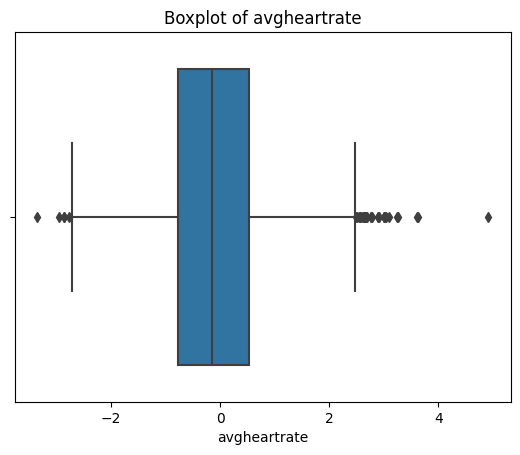

In [43]:
def plot_boxplot(df, column):
    df_numerical = get_numerical_df(df)

    sns.boxplot(x=df_numerical[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

plot_boxplot(hai_positive_patients_cleaned_df, 'avgheartrate')


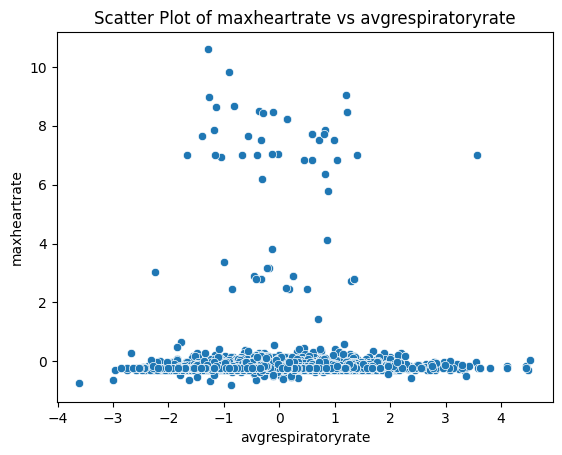

In [54]:
def plot_scatter(df, x_column, y_column, handle_missing=True, impute_strategy='drop'):
    
    # Handle missing values if flag is set
    if handle_missing:
        df = handle_missing_values(df, x_column, strategy=impute_strategy)
        
        df = handle_missing_values(df, y_column, strategy=impute_strategy)
    

    sns.scatterplot(x=x_column, y=y_column, data=df)
    plt.title(f'Scatter Plot of {y_column} vs {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

# Usage
plot_scatter(hai_positive_patients_cleaned_df, 'avgrespiratoryrate', 'maxheartrate')